[ ] Fix the latent variance calculations. (I think it's just taking total variance instead of the 2 norm of z vectors.)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv
0,281474976710657,191815,1,LUM,4797.2383,550.61346,15.421524,18.445875
1,281474976710663,214084,1,SEC11C,4801.7330,905.11600,14.925031,31.019386
2,281474976710672,191342,0,TCIM,4804.4920,596.05396,14.681485,22.270780
3,281474976710673,191574,0,STC1,4805.0483,414.38370,19.306356,16.183300
4,281474976710674,192193,0,STC1,4805.7170,273.81440,16.112896,26.251837


In [3]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [4]:
HIGHLY_VARIABLE = False
clustering.normalize_counts(clustering.xenium_spot_data)

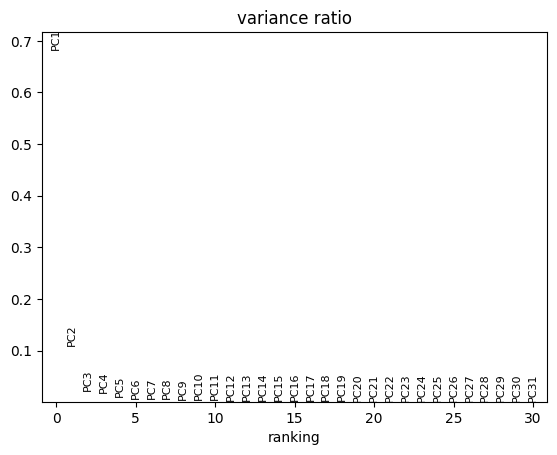

In [5]:
HIGHLY_VARIABLE = True
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
# generate the neigborhood graph based on pca
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

In [6]:
clustering.xenium_spot_data.var, clustering.xenium_spot_data.var.shape

(         highly_variable     means  dispersions  dispersions_norm
 ABCC11              True  2.953047     3.744833          1.381699
 ACTA2               True  3.785395     4.306623          0.855501
 ACTG2               True  2.702556     3.293917          0.277550
 ADH1B               True  2.189261     3.317184          1.345480
 ADIPOQ              True  1.312891     3.692371          2.333570
 ...                  ...       ...          ...               ...
 TRAF4               True  3.451874     3.772538          0.095950
 TRAPPC3             True  3.757066     3.888496         -0.408003
 TRIB1               True  2.911854     3.839642          1.613857
 TUBA4A              True  3.123837     3.380066          0.007989
 VWF                 True  2.611254     3.533479          0.757073
 
 [180 rows x 4 columns],
 (180, 4))

In [7]:
clustering.xenium_spot_data.obs, clustering.xenium_spot_data.obs.shape

(     spot_number    x_location   y_location z_location   row    col
 0             18     58.685923  1860.775855  11.995915  18.0    0.0
 1             19     48.868837  1948.936671  11.944450  19.0    0.0
 2             20     44.957070  2062.145073  11.886400  20.0    0.0
 3             21     64.296418  2135.863892  11.883457  21.0    0.0
 4             22     40.359721  2275.333869  12.084637  22.0    0.0
 ...          ...           ...          ...        ...   ...    ...
 7307        9145  10209.827800  6787.376660  24.731413  67.0  102.0
 7308        9146  10247.916375  6830.041012  24.520689  68.0  102.0
 7309        9147  10248.615000  6923.818400  24.694735  69.0  102.0
 7310        9231  10303.937000  6412.000000  24.712805  64.0  103.0
 7311        9232  10305.357000  6548.361000  24.396360  65.0  103.0
 
 [7312 rows x 6 columns],
 (7312, 6))

In [8]:
expression_data = pd.DataFrame(clustering.xenium_spot_data.X, columns=clustering.xenium_spot_data.var.index)
clustering.xenium_spot_data.obs.index = clustering.xenium_spot_data.obs.index.astype(int)
input_data = clustering.xenium_spot_data.obs.join(expression_data)
input_data.head()

,spot_number,x_location,y_location,z_location,row,col,ABCC11,ACTA2,ACTG2,ADH1B,...,TIGIT,TOP2A,TPD52,TPSAB1,TRAC,TRAF4,TRAPPC3,TRIB1,TUBA4A,VWF
0,18,58.685923,1860.775855,11.995915,18.0,0.0,0.0,0.693147,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.693147,0.0,0.0,0.0
1,19,48.868837,1948.936671,11.944450,19.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.098612,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,20,44.957070,2062.145073,11.886400,20.0,0.0,0.0,0.693147,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,21,64.296418,2135.863892,11.883457,21.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,22,40.359721,2275.333869,12.084637,22.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Reconstruction Loss

Input: $X$

Reconstruction: $X^{'}$

$$(X - X^{'})^2$$

### Spatial Loss

Left Boundary $(l)$: $\max(0, j - n)$

Right Boundary $(r)$: $\min(0, j + n)$

Top Boundary $(t)$: $\max(0, i - n)$

Bottom Boundary $(b)$: $\min(0, i + n)$

$$\frac{1}{IJ} \sum_{i=1}^I \sum_{j=1}^{J} \frac{1}{(r-l+1)(b-t+1)}\sum_{i^{'} = b}^{t} \sum_{j^{'}=l}^{r} D_{KL}(C[i^{'}, j^{'}], C[i, j]) $$

### Entropy Regularization

$$- \frac{1}{IJK} \sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K} p_{i,j}(k) \log(p_{i,j}(k)) $$

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "[1]"


In [10]:
class ClassifierAutoEncoder(L.LightningModule):

    def __init__(
            self, 
            within_cluster_distance_hyperparam = 1,
            within_cluster_penalty_hyperparam = 1, 
            spatial_penalty_hyperparam = 1,
            entropy_penalty_hyperparam = 1,
            cluster_util_penalty_hyperparam = 1,
            neighborhood_size = 5,
            num_clusters = 10
        ):

        self.within_cluster_distance_hyperparam = within_cluster_distance_hyperparam
        self.within_cluster_penalty_hyperparam = within_cluster_penalty_hyperparam
        self.spatial_penalty_hyperparam = spatial_penalty_hyperparam
        self.entropy_penalty_hyperparam = entropy_penalty_hyperparam
        self.cluster_util_penalty_hyperparam = cluster_util_penalty_hyperparam
        self.neighborhood_size = neighborhood_size
        self.num_clusters = num_clusters
        self.input_size = 180 if HIGHLY_VARIABLE else 541

        self.loss_array = []

        super(ClassifierAutoEncoder, self).__init__()

        # Encoder Layers
        self.enc_conv1 = torch.nn.Conv2d(self.input_size, 90, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm1 = torch.nn.BatchNorm2d(90)
        self.enc_conv2 = torch.nn.Conv2d(90, 45, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm2 = torch.nn.BatchNorm2d(45)
        self.enc_conv3 = torch.nn.Conv2d(45, 15, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm3 = torch.nn.BatchNorm2d(15)
        self.activation = torch.nn.LeakyReLU()

        # Decoder Layers
        self.dec_conv1 = torch.nn.Conv2d(15, 45, kernel_size=5, stride=1, padding=2)
        self.dec_batchnorm1 = torch.nn.BatchNorm2d(45)
        self.dec_conv2 = torch.nn.Conv2d(45, 90, kernel_size=5, stride=1, padding=2)
        self.dec_batchnorm2 = torch.nn.BatchNorm2d(90)
        self.dec_conv3 = torch.nn.Conv2d(90, self.input_size, kernel_size=5, stride=1, padding=2)

        self.clust_linear1 = torch.nn.Linear(15, 256)
        self.clust_linear2 = torch.nn.Linear(256, 128)
        self.clust_linear3 = torch.nn.Linear(128, self.num_clusters)
        self.clust_softmax = torch.nn.Softmax(dim=1)

        self.cluster_assignment = torch.nn.Sequential(
            self.clust_linear1,
            self.activation,
            self.clust_linear2,
            self.activation,
            self.clust_linear3,
            self.clust_softmax 
        )
        
    def training_step(self, batch, batch_idx):

        x, x_hat, z, cluster = self(batch)

        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        formatted_loss = round(loss.item(), 4)
        print(formatted_loss)
        self.loss_array.append(formatted_loss)
        print(f"# of Clusters: {cluster_masked.argmax(dim=1).unique().numel()}")

        return loss

    def validation_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

        # Apply mask to input and reconstruction
        x_masked = x * zeros
        x_hat_masked = x_hat * zeros
        z_masked = z * torch.flatten(zeros).view(-1,1)
        cluster_masked = cluster * torch.flatten(zeros).view(-1,1)

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss

    def test_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

        # Apply mask to input and reconstruction
        x_masked = x * zeros
        x_hat_masked = x_hat * zeros
        z_masked = z * torch.flatten(zeros).view(-1,1)
        cluster_masked = cluster * torch.flatten(zeros).view(-1,1)

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss

    def cluster_utilization_and_entropy_loss(self, cluster_probs, min_cluster_rate=0.1, beta=1.0):
        # Assuming cluster_probs is a Tensor of shape [N, num_clusters]
        # where N is the number of samples and num_clusters is the number of possible clusters.

        # Calculate the mean probability of each cluster being chosen across all samples
        mean_probs = torch.mean(cluster_probs, dim=0)
        
        # Calculate the shortfall for each cluster from the minimum rate
        shortfalls = min_cluster_rate - mean_probs
        
        # Apply ReLU to get positive shortfalls only (negative values become zero)
        positive_shortfalls = torch.nn.functional.relu(shortfalls)
        
        # Square the shortfalls to penalize larger deviations more severely
        squared_penalties = positive_shortfalls ** 2
        
        # Sum the squared penalties to get the total utilization loss
        utilization_loss = torch.sum(squared_penalties)
        
        # Calculate entropy of the mean probabilities to encourage confident predictions
        entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10))  # Adding a small constant to prevent log(0)
        
        # Total loss combines utilization loss and entropy scaled by a factor beta
        total_loss = utilization_loss + beta * entropy
        
        return total_loss


    def spatial_loss_function(self, input, reconstruction, latents, cluster_assignments):
        reconstruction_loss = F.mse_loss(input, reconstruction)
        within_cluster_penalty = self.within_cluster_average_latent_dissimilarity(latents, cluster_assignments)
        spatial_cluster_penalty = self.neighboring_cluster_dissimilarity(cluster_assignments, input)
        within_cluster_distance = self.within_cluster_distance(cluster_assignments, input)
        entropy_penalty = self.entropy_regularization(cluster_assignments, input)
        diff_clusters = self.cluster_utilization_and_entropy_loss(cluster_assignments)
        print(f"""LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              ({reconstruction_loss}, {self.within_cluster_penalty_hyperparam * within_cluster_penalty}, {self.within_cluster_distance_hyperparam * within_cluster_distance}, {self.spatial_penalty_hyperparam * spatial_cluster_penalty}, {self.cluster_util_penalty_hyperparam * diff_clusters})
              """)
        return reconstruction_loss + self.within_cluster_penalty_hyperparam * within_cluster_penalty + self.spatial_penalty_hyperparam * spatial_cluster_penalty + self.within_cluster_penalty_hyperparam * within_cluster_penalty + self.cluster_util_penalty_hyperparam * diff_clusters

    def within_cluster_average_latent_dissimilarity(self, z, cluster, margin=5.0, samples_per_cluster=25):
        cluster_assignments = cluster.argmax(dim=1)
        # Initialize triplet loss function
        triplet_loss = torch.nn.TripletMarginLoss(margin=margin)

        # Find unique clusters
        unique_clusters = cluster_assignments.unique()

        # Preparing lists to hold anchor, positive, and negative examples
        anchor_list = []
        positive_list = []
        negative_list = []

        # Loop through each cluster to select anchor and positive, and find negative from other clusters
        for cluster in unique_clusters:
            # Indices for current cluster and other clusters
            current_cluster_indices = (cluster_assignments == cluster).nonzero().squeeze()
            other_clusters_indices = (cluster_assignments != cluster).nonzero().squeeze()

            # Check if there are enough samples
            for _ in range(samples_per_cluster):
                if current_cluster_indices.numel() > 1 and other_clusters_indices.numel() > 1:
                    # Randomly choose one sample to be the anchor and another to be the positive sample
                    anchor_pos_indices = torch.randperm(len(current_cluster_indices))[:2]
                    anchor_index = current_cluster_indices[anchor_pos_indices[0]]
                    positive_index = current_cluster_indices[anchor_pos_indices[1]]

                    # Randomly choose one sample from another cluster to be the negative sample
                    negative_index = other_clusters_indices[torch.randperm(len(other_clusters_indices))[0]]

                    # Add to lists
                    anchor_list.append(z[anchor_index])
                    positive_list.append(z[positive_index])
                    negative_list.append(z[negative_index])

        # Stack lists to create tensors for the triplet loss calculation
        if anchor_list:
            anchor_tensor = torch.stack(anchor_list)
            positive_tensor = torch.stack(positive_list)
            negative_tensor = torch.stack(negative_list)

            # Calculate the triplet loss
            loss = triplet_loss(anchor_tensor, positive_tensor, negative_tensor) 
            return loss

        # Compute a penalty based on the norm of embeddings when no triplets are available
        penalty = torch.norm(1000. * z, p=2)  # You can adjust the norm type and scaling factor as needed
        return penalty
    

    def within_cluster_distance(self, cluster_probabilities, x):
        device = cluster_probabilities.device  # Get the device of the probabilities (presumably GPU)
        batch, channels, height, width = x.shape
        num_clusters = cluster_probabilities.size(1)
        
        # Reshape cluster probabilities and coordinates for pairwise distance computation
        cluster_probabilities = cluster_probabilities.view(height * width, num_clusters)
        coordinates = torch.stack(torch.meshgrid(torch.arange(height, device=device), torch.arange(width, device=device)), dim=-1)
        coordinates = coordinates.view(-1, 2).float()  # Flatten and convert to float
        coordinates /= max(height, width)  # Normalize coordinates

        # Calculate the pairwise probability that points belong to the same cluster
        same_cluster_probs = torch.matmul(cluster_probabilities, cluster_probabilities.t())

        # Compute pairwise distances for all points
        pairwise_distances = torch.cdist(coordinates, coordinates, p=2)

        # Weight distances by the pairwise cluster probabilities
        within_cluster_distances = same_cluster_probs * pairwise_distances

        # Since we've computed all pairs twice, we halve the result (and ignore the diagonal)
        mask = torch.ones(within_cluster_distances.size(), device=device).fill_diagonal_(0)
        within_cluster_distances *= mask

        # Sum over upper triangle matrix to avoid double-counting pairs
        total_within_cluster_distance = within_cluster_distances.triu(diagonal=1).sum()

        return total_within_cluster_distance

    
    def neighboring_cluster_dissimilarity(self, cluster, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster.shape
        spatial_cluster = cluster.view(height, width, num_clusters)
        dissimilarity_values = []
        for i in range(height):
            for j in range(width):

                left_boundary = max(0, j - self.neighborhood_size)
                right_boundary = min(width, j + self.neighborhood_size + 1)
                top_boundary = max(0, i - self.neighborhood_size)
                bottom_boundary = min(height, i + self.neighborhood_size + 1)
                neighborhood = spatial_cluster[top_boundary:bottom_boundary, left_boundary:right_boundary]

                central_pixel_distr = spatial_cluster[i, j, :].unsqueeze(0).unsqueeze(0)
                kl_divergences = F.kl_div((central_pixel_distr + zero_correction).log(), neighborhood + zero_correction, reduction='none', log_target=False)
                dissimilarity = kl_divergences.sum(dim=-1).mean(dim=(0, 1))

                dissimilarity_values.append(dissimilarity.unsqueeze(0))

        dissimilarities = torch.cat(dissimilarity_values).to(x.device)
        return torch.sum(dissimilarities)  
    
    def entropy_regularization(self, cluster_probs, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster_probs.shape
        spatial_cluster = cluster_probs.view(height, width, num_clusters)
        entropy = -torch.sum(spatial_cluster * torch.log(spatial_cluster + zero_correction), dim=2)
        entropy_loss = torch.mean(entropy)
        return entropy_loss

    def forward(self, x):

        # Encoding path
        x1 = self.enc_conv1(x)
        x1 = self.enc_batchnorm1(x1)
        x1 = self.activation(x1)
        
        x2 = self.enc_conv2(x1)
        x2 = self.enc_batchnorm2(x2)
        x2 = self.activation(x2)
        
        x3 = self.enc_conv3(x2)
        x3 = self.enc_batchnorm3(x3)
        z = self.activation(x3)

        # Decoding path
        d1 = self.dec_conv1(x3)
        d1 = self.dec_batchnorm1(d1)
        d1 = self.activation(d1)
        d1 += x2  # Residual connection from x3 to d1

        d2 = self.dec_conv2(d1)
        d2 = self.dec_batchnorm2(d2)
        d2 = self.activation(d2)
        d2 += x1  # Residual connection from x2 to d2

        x_hat = self.dec_conv3(d2)

        # Flattening for clustering
        batch_size, channels, height, width = z.size()
        z = z.view(batch_size * height * width, channels)
        cluster = self.cluster_assignment(z)

        return x, x_hat, z, cluster  # Return the original, reconstructed, and cluster probabilities

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [11]:
gene_data = []

for gene in clustering.xenium_spot_data.var.index:
    gene_channel = pd.pivot(input_data, index = 'row', columns = 'col', values = f"{gene}").fillna(0)
    gene_tensor = torch.tensor(gene_channel.to_numpy())
    gene_data.append(gene_tensor)

input_tensor = torch.stack(gene_data, dim=0)
input_tensor.shape

torch.Size([180, 88, 104])

In [12]:
input_tensor = input_tensor.float()
input_tensor.to(dtype=torch.float32)
print(input_tensor.shape)
dataset = [input_tensor]
dataloader = DataLoader(dataset, batch_size=1)

model = ClassifierAutoEncoder(within_cluster_distance_hyperparam = 1e-6, within_cluster_penalty_hyperparam = 0.5, spatial_penalty_hyperparam = 1, cluster_util_penalty_hyperparam = 1, neighborhood_size = 30)

torch.Size([180, 88, 104])


In [13]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name               | Type        | Params
----------------------------------------------------
0  | enc_conv1          | Conv2d      | 405 K 
1  | enc_batchnorm1     | BatchNorm2d | 180   
2  | enc_conv2          | Conv2d      | 101 K 
3  | enc_batchnorm2     | BatchNorm2d | 90    
4  | enc_conv3          | Conv2d      | 16.9 K
5  | enc_batchnorm3     | BatchNorm2d | 30    
6  | activation         | LeakyReLU   | 0     
7  | dec_conv1          | Conv2d      | 16.9 K
8  | dec_batchnorm1     | BatchNorm2d | 90    
9  | dec_conv2          | Conv2d      | 101 K 
10 | dec_batchnorm2     | BatchNorm2d | 180   
11 | dec_conv3          | Conv2d      | 405 K 
12 | clust_linear1      | Linear      | 4.1 K 
13 | clust_linear2      | Linear      | 32.9 K
14 | clust_linear3      | Linear      | 1.3 K 
15 | clust_softmax      | Softmax     | 0     


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] The masking procedure did not work.
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              (4.034327983856201, 2.1705193519592285, 2.0257527828216553, 16.947481155395508, 2.301098108291626)
              
27.6239
# of Clusters: 10
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=298]        The masking procedure did not work.
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              (3.513932228088379, 2.1359119415283203, 2.025449752807617, 13.944793701171875, 2.301164388656616)
              
24.0317
# of Clusters: 8
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=298]        The masking procedure did not work.
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              (3.0904810428619385, 2.0165891647338867, 2.0251994132995605, 10.771537780761719, 2.301

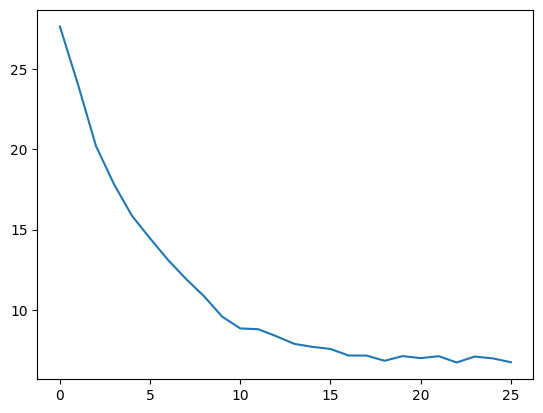

In [14]:
plt.plot(range(len(model.loss_array)), model.loss_array)

In [15]:
predictions = trainer.predict(model = model, dataloaders = dataloader)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


In [16]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
clusters

tensor([[0.0977, 0.1082, 0.0964,  ..., 0.0958, 0.1079, 0.1002],
        [0.0976, 0.1092, 0.0964,  ..., 0.0954, 0.1074, 0.0993],
        [0.0978, 0.1097, 0.0969,  ..., 0.0950, 0.1072, 0.0998],
        ...,
        [0.0985, 0.1081, 0.0968,  ..., 0.0958, 0.1065, 0.1006],
        [0.0985, 0.1081, 0.0968,  ..., 0.0958, 0.1065, 0.1006],
        [0.0985, 0.1081, 0.0968,  ..., 0.0957, 0.1065, 0.1006]])

(array([7.429e+03, 0.000e+00, 9.900e+01, 0.000e+00, 0.000e+00, 2.800e+01,
        0.000e+00, 1.593e+03, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

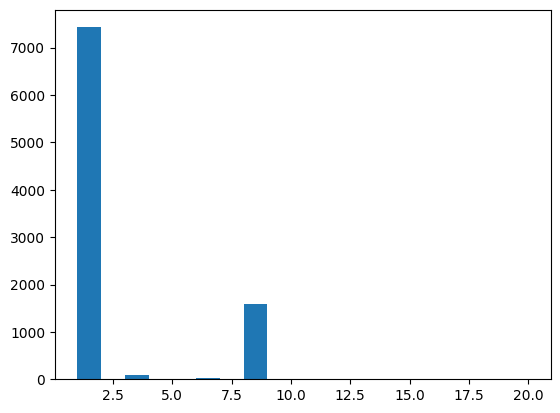

In [17]:
clusters.argmax(dim=1)
plt.hist(clusters.argmax(dim=1), bins=range(1, 21))

In [18]:
inputs.shape

torch.Size([1, 180, 88, 104])

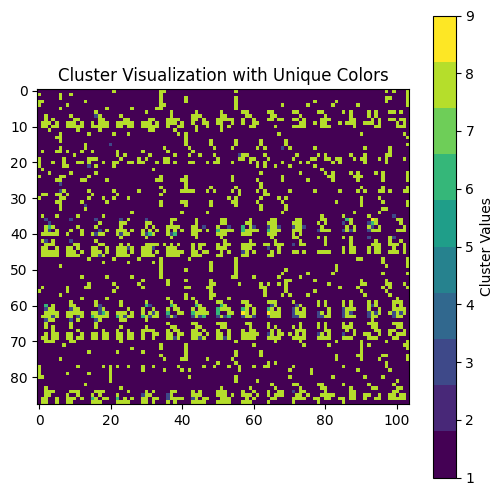

In [19]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1]

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
clusters = clusters.argmax(dim=1).view(height, width)
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

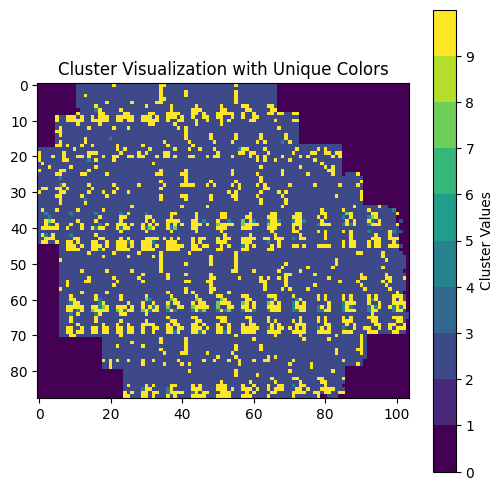

In [20]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1]

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
zeros = inputs.view(channels, height, width)
zeros = (zeros.sum(dim=0) != 0)
zeros = torch.tensor(zeros, dtype=int)
clusters = clusters.argmax(dim=1).view(height, width)
clusters = (clusters + 1) * zeros
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

In [ ]:
colormap

Metric Learning: Introducing a metric learning component, such as triplet loss or contrastive loss, could further encourage within-cluster compactness and between-cluster separation, which can be more effective than variance for certain types of data.

Post-Processing: After training, some post-processing steps like density-based spatial clustering (e.g., DBSCAN) can be applied to the latent representations to refine the cluster assignments and ensure smoothness.

Cluster Number: The number of clusters is fixed at 3 in your current setup. Experimenting with different numbers of clusters or even using techniques to dynamically determine the number of clusters could yield better results.

Your current method for spatial regularization, which penalizes cluster label changes within local neighborhoods, is a creative solution. It resembles the "smoothness" constraint in semi-supervised learning and graph-based clustering, which assumes that points in a small neighborhood are likely to share the same label or cluster assignment. However, ensure that this spatial term is not too strong to overpower the data-driven aspects of the clustering or lead to trivial solutions where the model simply assigns everything to one cluster to minimize the penalty. This balancing act can be delicate and may require careful tuning of your hyperparameters.